In [13]:
!pip install tensorflow
!pip install keras
!pip install efficientnet

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from efficientnet.tfkeras import EfficientNetB0


data_dir = "/content/drive/MyDrive/Teeth_Dataset"
train_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Training")
val_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Validation")
test_dir = os.path.join(data_dir, "/content/drive/MyDrive/Teeth_Dataset/Testing")

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.5 MB/s eta 0:00:00
Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


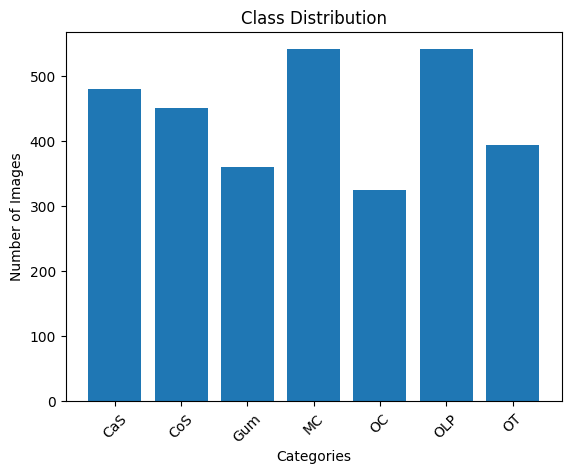

In [14]:
class_labels = list(train_generator.class_indices.keys())
class_counts = [len(os.listdir(os.path.join(train_dir, label))) for label in class_labels]
plt.bar(class_labels, class_counts)
plt.title("Class Distribution")
plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()


In [15]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

model.summary()

16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnet-b0 (Functional)         │ (None, 7, 7, 1280)          │       4,049,564 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,223,011 (16.11 MB)

 Trainable params: 1,066,295 (4.07 MB)

 Non-trainable params: 3,156,716 (12.04 MB)

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'teeth_classification.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [19]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

In [20]:
history = model.fit(train_generator, validation_data=val_generator, epochs=50 ,  callbacks=[checkpoint, early_stopping, reduce_lr_on_plateau])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 105s 785ms/step - accuracy: 0.2432 - loss: 2.0004 - val_accuracy: 0.5778 - val_loss: 1.4654 - learning_rate: 1.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 531ms/step - accuracy: 0.5490 - loss: 1.2730 - val_accuracy: 0.7451 - val_loss: 1.0126 - learning_rate: 1.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 526ms/step - accuracy: 0.6639 - loss: 1.0271 - val_accuracy: 0.8025 - val_loss: 0.7249 - learning_rate: 1.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 83s 538ms/step - accuracy: 0.7467 - loss: 0.8536 - val_accuracy: 0.8648 - val_loss: 0.5515 - learning_rate: 1.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 528ms/step - accuracy: 0.7857 - loss: 0.7440 - val_accuracy: 0.8969 - val_loss: 0.4551 - learning_rate: 1.0000e-04
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 541ms/step - accuracy: 0.8023 - loss: 0.6706 - val_accuracy: 0.9261 - val_loss: 0.3726 - learning_rate: 1.0000e-04
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 540ms/step - ac

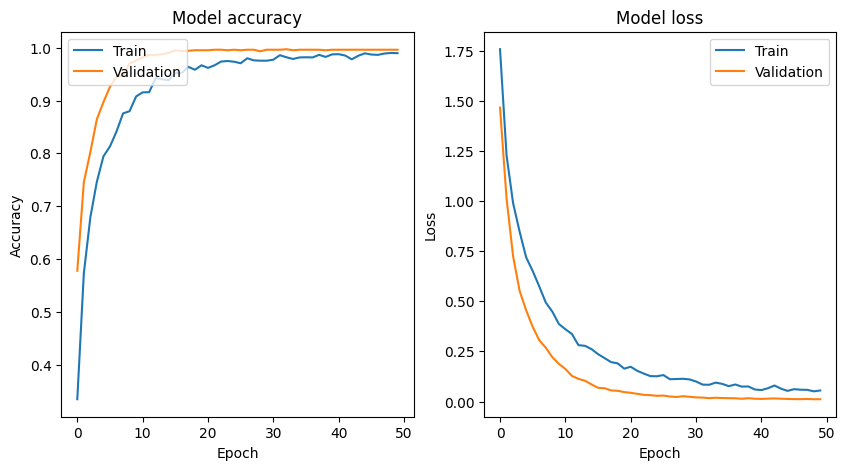

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

In [22]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9989 - loss: 0.0062
Test Loss: 0.0086
Test Accuracy: 99.81%


In [25]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step


In [24]:
from sklearn.metrics import confusion_matrix

In [26]:
cm = confusion_matrix(true_classes, predicted_classes)

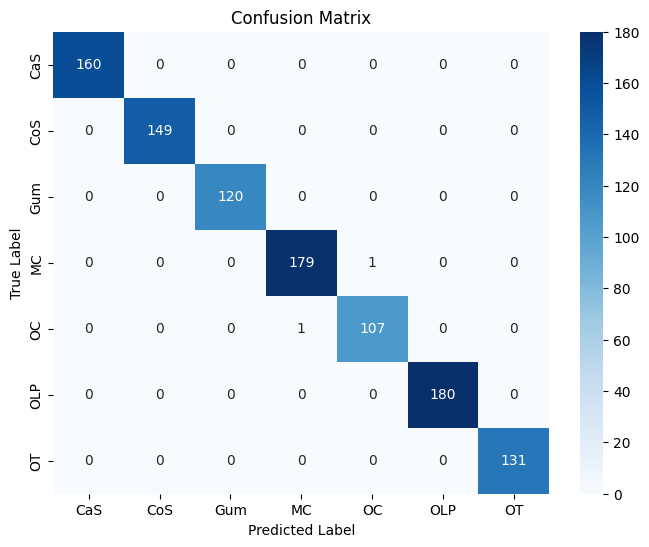

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [29]:
from sklearn.metrics import classification_report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

         CaS       1.00      1.00      1.00       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.99      0.99      0.99       180
          OC       0.99      0.99      0.99       108
         OLP       1.00      1.00      1.00       180
          OT       1.00      1.00      1.00       131

    accuracy                           1.00      1028
   macro avg       1.00      1.00      1.00      1028
weighted avg       1.00      1.00      1.00      1028

